# Imports

In [1]:
from scikeras.wrappers import KerasRegressor
import tensorflow as tf
from tensorflow import keras
import pickle
from datetime import datetime as dt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings
import calendar
import collections.abc
collections.Iterable = collections.abc.Iterable
warnings.filterwarnings("ignore")

2023-03-24 04:05:56.554873: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 04:06:12.624916: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-24 04:06:12.625030: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-24 04:06:12.625038: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-03-24 04:06:26.841999: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 04:06:31.000620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 04:06:31.000779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# Data Ingestion and Preparation

In [3]:
train = pd.read_csv('train.csv', index_col='date')
train.index = pd.to_datetime(train.index)
train = pd.pivot_table(train, values='sales', index="date", columns=['store_nbr', 'family'], aggfunc=np.sum)
train.columns = [f"{a[0]}_{a[1].replace('/','_')}" for a in train.columns]
test = pd.read_csv('test.csv', index_col='date')
test.index = pd.to_datetime(test.index)

In [4]:
X = train
Y = train.shift(-1, fill_value=0)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=5, shuffle=False)
X_test_copy = X_test
X_test_index = X_test.index
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.values.reshape(y_train.shape[0], 1782, 1)
y_test = y_test.values.reshape(y_test.shape[0], 1782, 1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1515, 1782, 1)
(169, 1782, 1)
(1515, 1782, 1)
(169, 1782, 1)


# RNN model

In [5]:
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=10, min_delta=0.05)

In [6]:
rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[X_train.shape[1], X_train.shape[2]]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1)
])
rnn.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=tf.keras.optimizers.Adam())
rnn.summary()
rnn.fit(X_train, y_train, epochs=100, callbacks=[es])
pred_rnn = abs(rnn.predict(X_test))

2023-03-24 04:06:37.073628: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 04:06:37.113930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 04:06:37.114109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 04:06:37.114234: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1782, 100)         10200     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 1782, 100)         20100     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 1782, 100)         20100     
                                                                 
 dense (Dense)               (None, 1782, 1)           101       
                                                                 
Total params: 50,501
Trainable params: 50,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-03-24 04:06:56.840794: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f54f80a3df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-24 04:06:56.840817: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-03-24 04:06:57.294648: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-24 04:07:00.242718: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


48/48 [==============================] - 116s 2s/step - loss: 6.0806
Epoch 2/100
48/48 [==============================] - 101s 2s/step - loss: 4.6425
Epoch 3/100
48/48 [==============================] - 99s 2s/step - loss: 4.1946
Epoch 4/100
48/48 [==============================] - 103s 2s/step - loss: 3.8735
Epoch 5/100
48/48 [==============================] - 99s 2s/step - loss: 3.6313
Epoch 6/100
48/48 [==============================] - 102s 2s/step - loss: 3.4365
Epoch 7/100
48/48 [==============================] - 103s 2s/step - loss: 3.2719
Epoch 8/100
48/48 [==============================] - 103s 2s/step - loss: 3.1355
Epoch 9/100
48/48 [==============================] - 103s 2s/step - loss: 3.0148
Epoch 10/100
48/48 [==============================] - 100s 2s/step - loss: 2.9126
Epoch 11/100
48/48 [==============================] - 98s 2s/step - loss: 2.8209
Epoch 12/100
48/48 [==============================] - 102s 2s/step - loss: 2.7344
Epoch 13/100
48/48 [====================

In [7]:
print(pred_rnn.shape)
pred_rnn

(169, 1782, 1)


array([[[3.13162565e+00],
        [9.40127015e-01],
        [2.00550175e+00],
        ...,
        [1.45430588e+02],
        [3.17476392e-01],
        [2.26822281e+00]],

       [[2.24591827e+00],
        [5.26040673e-01],
        [2.50926733e+00],
        ...,
        [1.45397507e+02],
        [1.20865226e-01],
        [4.25453234e+00]],

       [[2.24816799e+00],
        [1.77690613e+00],
        [4.00327110e+00],
        ...,
        [1.45381683e+02],
        [6.58118725e-03],
        [3.22148848e+00]],

       ...,

       [[2.24591827e+00],
        [5.26040673e-01],
        [1.56741512e+00],
        ...,
        [1.45417084e+02],
        [1.46332145e-01],
        [1.72440135e+00]],

       [[2.24591827e+00],
        [5.26040673e-01],
        [3.88898182e+00],
        ...,
        [1.45358627e+02],
        [2.57499814e-01],
        [9.13275123e-01]],

       [[2.16028833e+00],
        [2.56163025e+00],
        [2.53426933e+00],
        ...,
        [1.45443069e+02],
        [2.1512

In [8]:
pred_rnn = pred_rnn.reshape(169, 1782)
pred = pd.DataFrame(pred_rnn, columns=X.columns, index=X_test_index)
pred

,1_AUTOMOTIVE,1_BABY CARE,1_BEAUTY,1_BEVERAGES,1_BOOKS,1_BREAD_BAKERY,1_CELEBRATION,1_CLEANING,1_DAIRY,1_DELI,...,54_MAGAZINES,54_MEATS,54_PERSONAL CARE,54_PET SUPPLIES,54_PLAYERS AND ELECTRONICS,54_POULTRY,54_PREPARED FOODS,54_PRODUCE,54_SCHOOL AND OFFICE SUPPLIES,54_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-02-28,3.131626,0.940127,2.005502,145.434113,0.723986,140.116959,5.003486,145.139725,145.373474,71.816170,...,0.518683,66.644104,144.901810,0.004436,4.759746,72.591469,59.596935,145.430588,0.317476,2.268223
2017-03-01,2.245918,0.526041,2.509267,145.427948,0.678250,145.433578,10.277312,145.456665,145.445923,139.475922,...,1.105945,72.876984,145.120300,1.243461,3.111595,65.667503,51.362659,145.397507,0.120865,4.254532
2017-03-02,2.248168,1.776906,4.003271,145.436111,0.606269,145.419601,12.379835,145.455933,145.441650,123.874817,...,0.781112,62.935173,145.108673,0.047902,2.605171,67.659134,53.652061,145.381683,0.006581,3.221488
2017-03-03,2.914533,3.234763,3.995429,145.436096,0.566793,145.430206,12.426010,145.457001,145.443802,143.139572,...,1.089380,68.952583,145.014313,0.056733,3.196102,67.260086,55.418373,145.402466,0.141746,1.559536
2017-03-04,4.358467,3.823153,2.740965,145.441376,1.010905,145.415543,6.325305,145.452744,145.446014,119.882843,...,1.037950,62.837872,145.242538,0.199756,3.476664,42.056442,72.074326,145.353394,0.223936,1.941605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,2.245918,0.526041,1.567415,145.418915,0.753632,141.644424,4.268618,145.260178,145.374222,71.444656,...,0.223201,69.100510,144.433044,0.104697,0.860183,95.807304,45.943996,145.326355,0.458800,0.709455
2017-08-12,4.358467,3.823153,2.244023,145.441757,0.729004,145.055649,4.478680,145.378296,145.426346,97.092743,...,0.735446,67.227753,144.752991,0.168197,2.932226,99.225273,68.615211,145.422440,0.120397,1.369484
2017-08-13,2.245918,0.526041,1.567415,145.403503,0.667285,140.890823,2.674837,144.439148,145.024490,63.470299,...,1.250850,75.816154,145.118225,0.176121,2.848880,77.431404,68.085701,145.417084,0.146332,1.724401


In [9]:
def compare(column):
    df_test = X_test_copy[column]
    prediction = pred[column]
    df_test.plot(figsize=(25, 10))
    prediction.plot()
    print(f"R2 Score: {r2_score(df_test, prediction)}")
    print(f"RMSLE: {mean_squared_log_error(df_test, prediction, squared=False)}")

R2 Score: -5.629140728908288
RMSLE: 0.7509619060115394


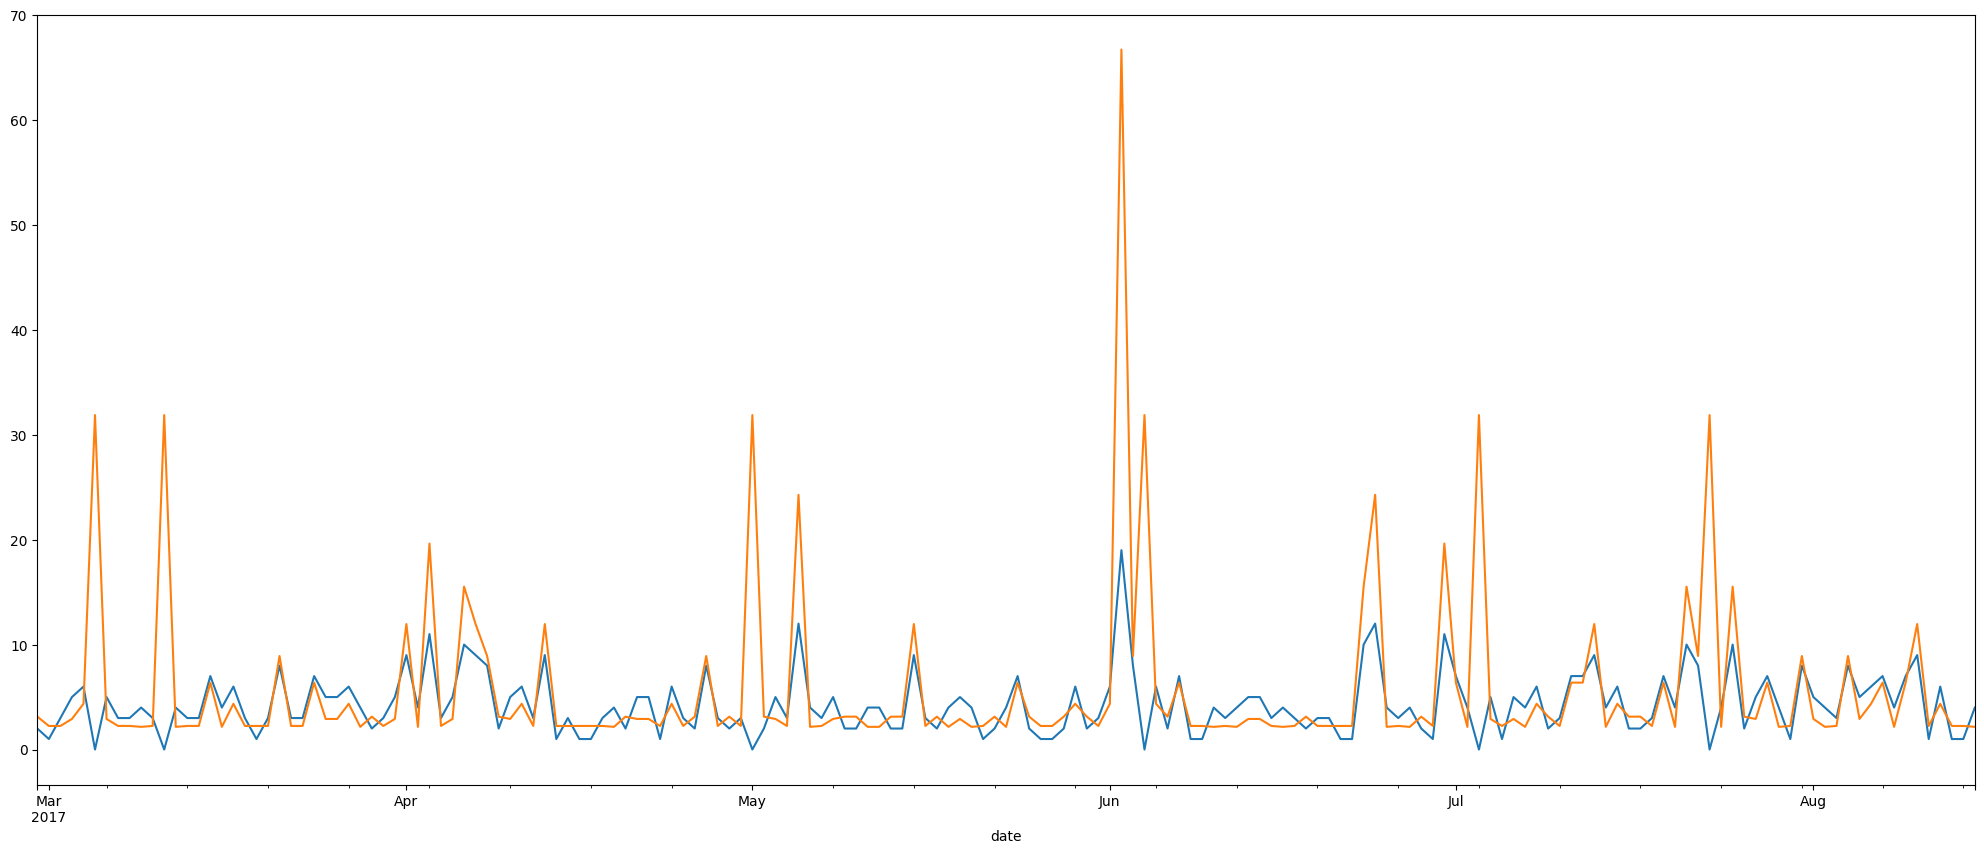

In [10]:
compare('1_AUTOMOTIVE')

R2 Score: -5.45355294627636
RMSLE: 1.4965529644100983


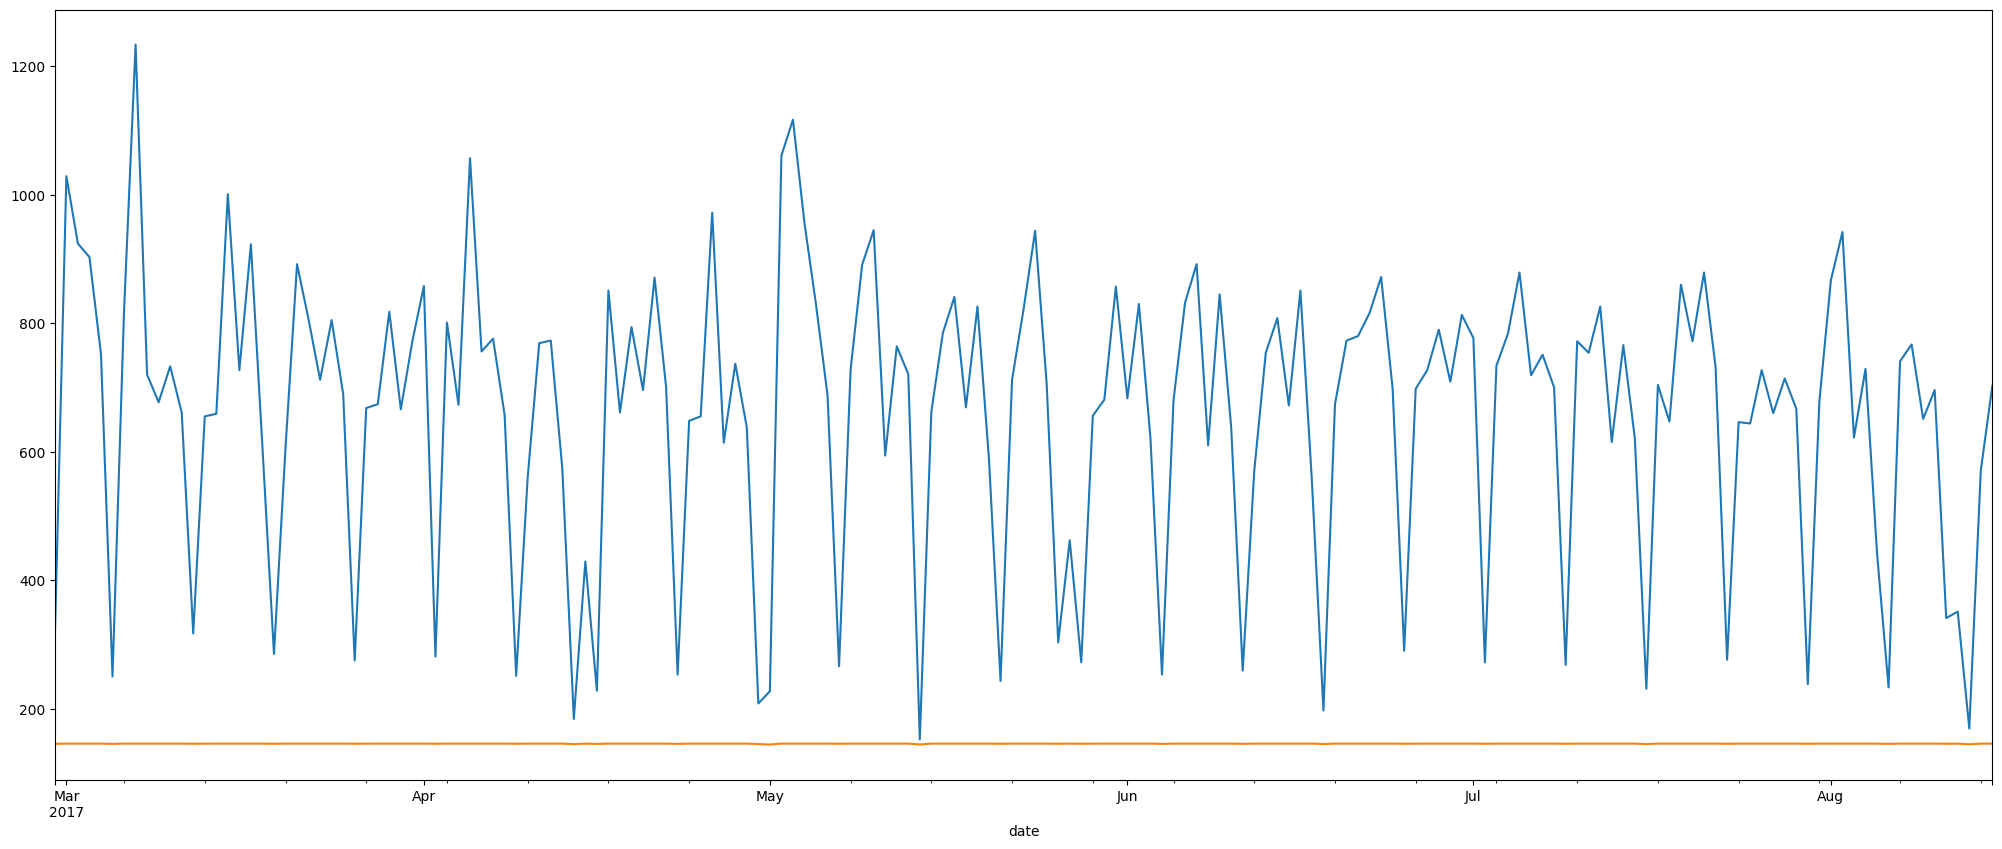

In [11]:
compare('1_CLEANING')

R2 Score: -8.627133108237661
RMSLE: 1.5831599767374152


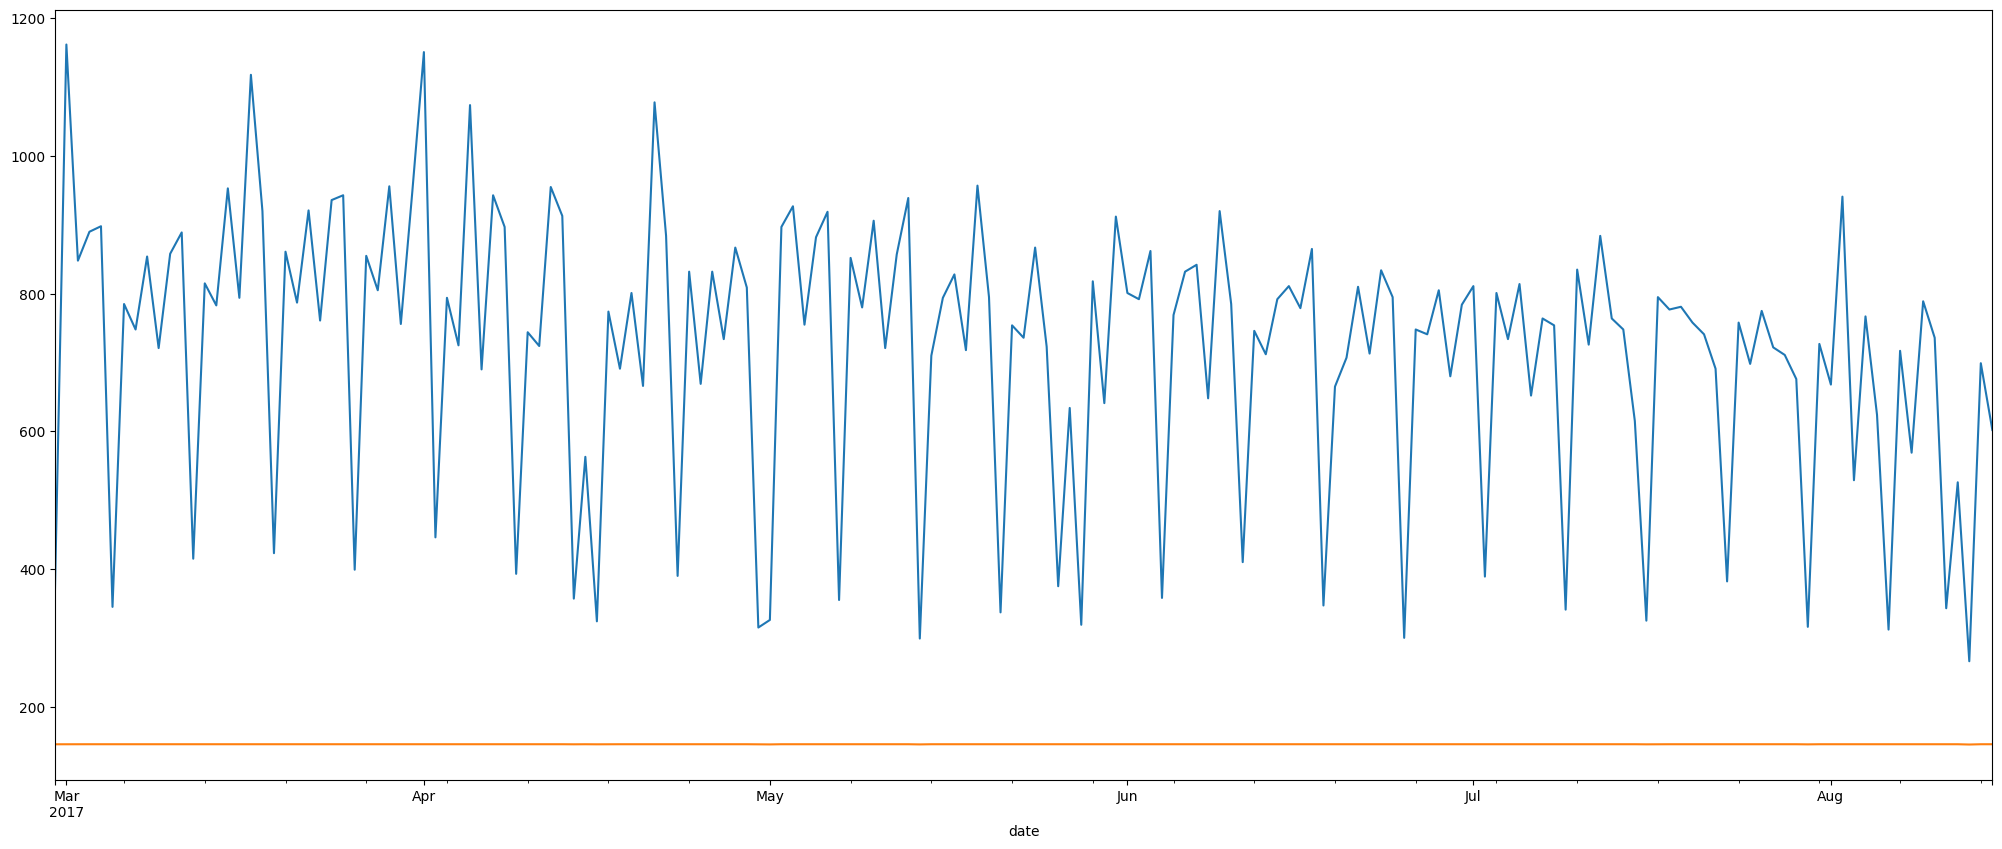

In [12]:
compare('1_DAIRY')

R2 Score: 0.6382852565297539
RMSLE: 0.16070259516148533


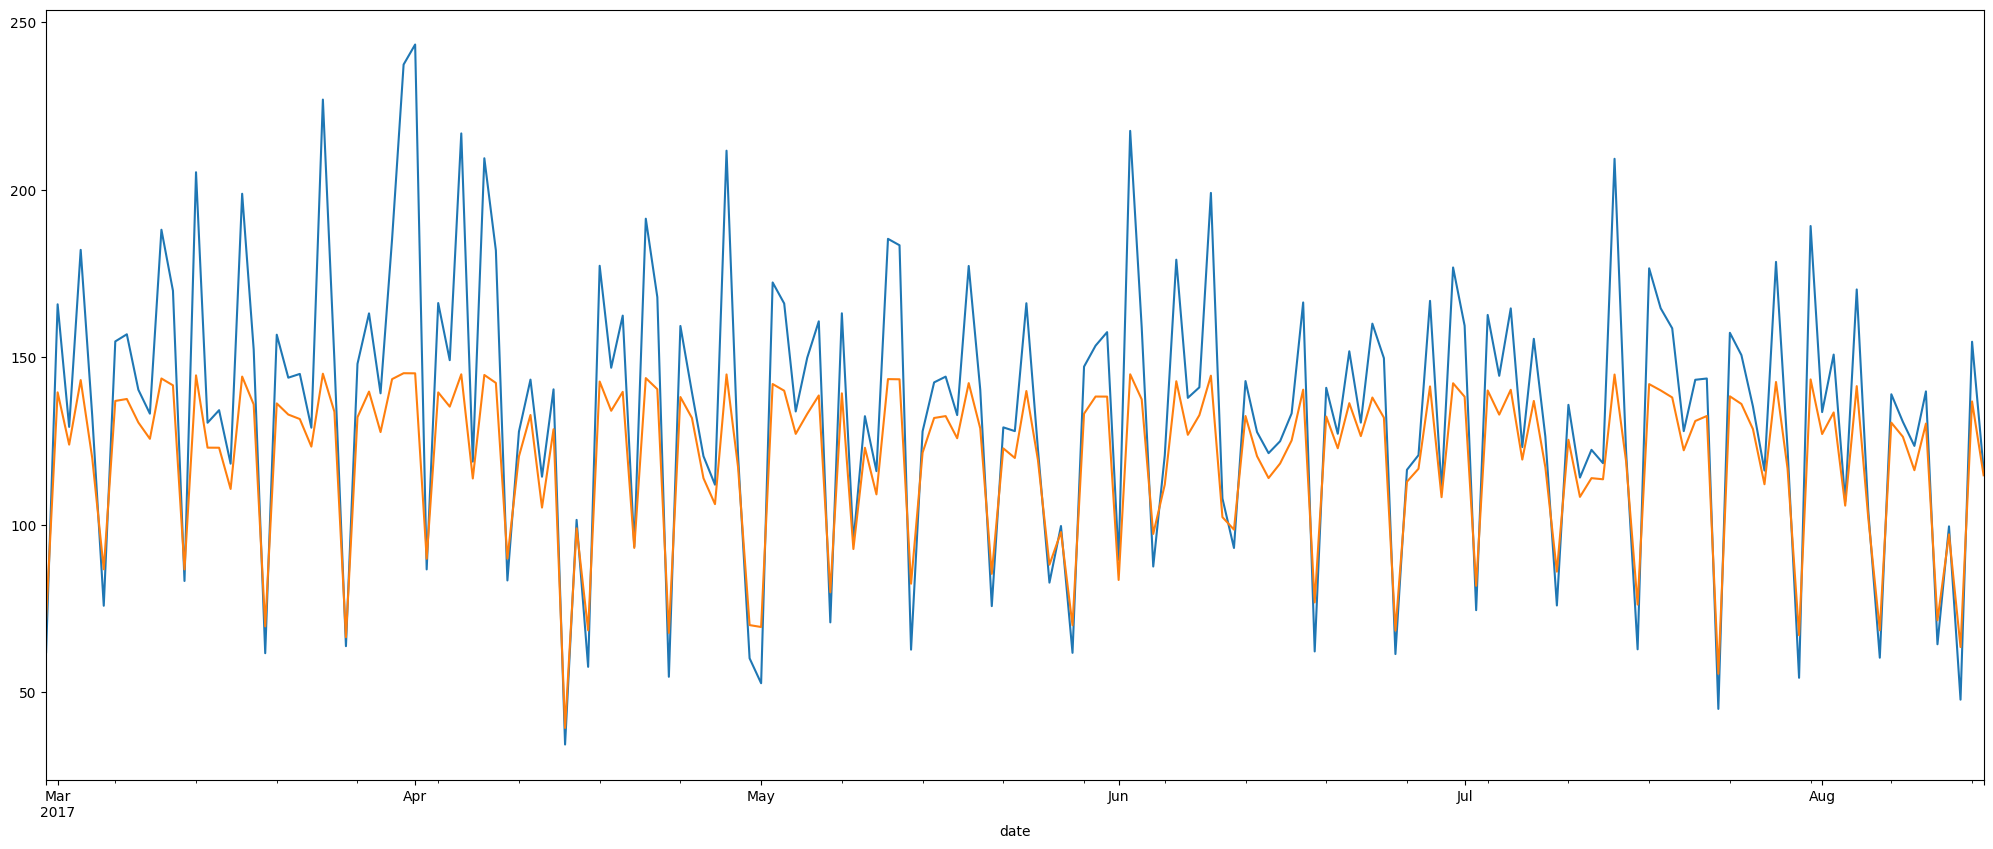

In [13]:
compare('1_DELI')

## RNN Submission

In [14]:
Y = pd.DataFrame()
for feature in train.columns:
    for step in range(1, 17):
        Y[f'{feature}_step_ahead_{step}'] = train[feature].shift(-step, fill_value=0)
Y

,1_AUTOMOTIVE_step_ahead_1,1_AUTOMOTIVE_step_ahead_2,1_AUTOMOTIVE_step_ahead_3,1_AUTOMOTIVE_step_ahead_4,1_AUTOMOTIVE_step_ahead_5,1_AUTOMOTIVE_step_ahead_6,1_AUTOMOTIVE_step_ahead_7,1_AUTOMOTIVE_step_ahead_8,1_AUTOMOTIVE_step_ahead_9,1_AUTOMOTIVE_step_ahead_10,...,54_SEAFOOD_step_ahead_7,54_SEAFOOD_step_ahead_8,54_SEAFOOD_step_ahead_9,54_SEAFOOD_step_ahead_10,54_SEAFOOD_step_ahead_11,54_SEAFOOD_step_ahead_12,54_SEAFOOD_step_ahead_13,54_SEAFOOD_step_ahead_14,54_SEAFOOD_step_ahead_15,54_SEAFOOD_step_ahead_16
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2.0,3.0,3.0,5.0,2.0,0.0,2.0,2.0,2.0,3.0,...,1.0,1.0,1.0,0.0,1.0,5.0,0.0,2.0,1.0,2.0
2013-01-02,3.0,3.0,5.0,2.0,0.0,2.0,2.0,2.0,3.0,2.0,...,1.0,1.0,0.0,1.0,5.0,0.0,2.0,1.0,2.0,0.0
2013-01-03,3.0,5.0,2.0,0.0,2.0,2.0,2.0,3.0,2.0,2.0,...,1.0,0.0,1.0,5.0,0.0,2.0,1.0,2.0,0.0,1.0
2013-01-04,5.0,2.0,0.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,...,0.0,1.0,5.0,0.0,2.0,1.0,2.0,0.0,1.0,7.0
2013-01-05,2.0,0.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,1.0,...,1.0,5.0,0.0,2.0,1.0,2.0,0.0,1.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,6.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-12,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-13,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
X = train
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=5, shuffle=False)
X_test_copy = X_test
X_test_index = X_test.index
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.values.reshape(y_train.shape[0], 1782, 16)
y_test = y_test.values.reshape(y_test.shape[0], 1782, 16)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1515, 1782, 1)
(169, 1782, 1)
(1515, 1782, 16)
(169, 1782, 16)


In [16]:
rnn = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[X_train.shape[1], X_train.shape[2]]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(16)
])
rnn.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=tf.keras.optimizers.Adam())
rnn.summary()
rnn.fit(X_train, y_train, epochs=10, callbacks=[es])
pred_rnn = abs(rnn.predict(X_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 1782, 100)         10200     
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 1782, 100)         20100     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 1782, 100)         20100     
                                                                 
 dense_1 (Dense)             (None, 1782, 16)          1616      
                                                                 
Total params: 52,016
Trainable params: 52,016
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
48/48 [==============================] - 101s 2s/step - loss: 9.2796
Epoch 2/10
48/48 [==============================] - 100s 2s/step - loss: 6.6270
Epoch 3/10
48/48 [====

In [17]:
pred = pd.DataFrame(pred_rnn[168].T, columns=X.columns, index=test.index.unique())
pred

,1_AUTOMOTIVE,1_BABY CARE,1_BEAUTY,1_BEVERAGES,1_BOOKS,1_BREAD_BAKERY,1_CELEBRATION,1_CLEANING,1_DAIRY,1_DELI,...,54_MAGAZINES,54_MEATS,54_PERSONAL CARE,54_PET SUPPLIES,54_PLAYERS AND ELECTRONICS,54_POULTRY,54_PREPARED FOODS,54_PRODUCE,54_SCHOOL AND OFFICE SUPPLIES,54_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,23.949478,0.022025,7.393007,27.649307,0.673258,27.631035,18.053852,27.658627,27.654669,27.647505,...,1.634592,27.522823,27.646723,0.082327,1.835142,27.376221,27.639240,27.656357,0.150376,2.636014
2017-08-17,19.295212,0.026506,6.803996,22.200602,0.355693,22.186852,15.595874,22.207607,22.203676,22.197880,...,1.763421,22.101582,22.198107,0.043343,1.746956,22.016270,22.193283,22.205524,0.050243,2.542192
2017-08-18,21.430401,0.229292,6.738622,24.445606,0.514172,24.430542,16.428757,24.454210,24.450420,24.443502,...,1.757535,24.337309,24.443840,0.055591,1.816512,24.202971,24.436035,24.452074,0.047862,2.659863
2017-08-19,18.581877,0.218938,6.324275,21.047060,0.354120,21.032469,14.888548,21.055792,21.050434,21.045206,...,1.666489,20.968344,21.046223,0.148875,1.754256,20.842649,21.039431,21.051632,0.153229,2.463846
2017-08-20,18.890495,0.310463,6.675079,21.766695,0.137582,21.751957,14.585492,21.774881,21.771685,21.766172,...,1.452144,21.679188,21.766365,0.320348,1.715784,21.549904,21.761436,21.773476,0.159712,2.457668
2017-08-21,20.780497,0.186507,6.861948,23.691765,0.421166,23.677748,16.076199,23.699099,23.694901,23.688744,...,1.539667,23.595619,23.687412,0.062583,1.543502,23.479113,23.680037,23.696630,0.050734,2.421156
2017-08-22,21.377169,0.154998,6.655513,24.632399,0.074882,24.621008,16.313671,24.642460,24.639622,24.632710,...,1.888462,24.523981,24.633736,0.251560,1.732848,24.396837,24.625353,24.640982,0.224555,2.452374
2017-08-23,20.797230,0.101878,6.567644,23.615328,0.335259,23.600496,16.295732,23.623520,23.622116,23.616800,...,1.649927,23.511299,23.615435,0.106373,1.750310,23.378004,23.607695,23.623009,0.081537,2.399113
2017-08-24,23.578846,0.028079,6.771803,27.144262,0.418664,27.126432,18.005552,27.153845,27.149109,27.142305,...,1.844916,27.026514,27.141310,0.134833,1.916497,26.863022,27.134634,27.151188,0.114469,2.729407


In [18]:
id = []
sales = []
for i in test.id:
    row = test[test['id'] == i]
    column = f"{row['store_nbr'][0]}_{row['family'][0].replace('/', '_')}"
    value = pred[column][pred.index == row.index[0]][0]
    # The info from the ID row is taken and used to form a variable called column. 
    # This column variable refers to the correct store in the dataframe and the equality check on the indexes refer to the proper dates lining up.
    id.append(i)
    sales.append(value)
rnn_submission = pd.DataFrame({'id': id, 'sales': sales})
rnn_submission

,id,sales
0,3000888,23.949478
1,3000889,0.022025
2,3000890,7.393007
3,3000891,27.649307
4,3000892,0.673258
...,...,...
28507,3029395,24.916695
28508,3029396,24.920856
28509,3029397,24.935055
28510,3029398,24.915802


In [19]:
rnn_submission.to_csv('RNN_submission.csv', header=True, index=False)

# LSTM

In [20]:
X = train
Y = train.shift(-1, fill_value=0)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=5, shuffle=False)
X_test_copy = X_test
X_test_index = X_test.index
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.values.reshape(y_train.shape[0], 1782, 1)
y_test = y_test.values.reshape(y_test.shape[0], 1782, 1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1515, 1782, 1)
(169, 1782, 1)
(1515, 1782, 1)
(169, 1782, 1)


In [21]:
lstm = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[X_train.shape[1], X_train.shape[2]]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.Dense(1)
])
lstm.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=tf.keras.optimizers.Adam())
lstm.summary()
lstm.fit(X_train, y_train, epochs=100, callbacks=[es])
pred_lstm = abs(lstm.predict(X_test))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1782, 100)         40800     
                                                                 
 lstm_1 (LSTM)               (None, 1782, 100)         80400     
                                                                 
 lstm_2 (LSTM)               (None, 1782, 100)         80400     
                                                                 
 dense_2 (Dense)             (None, 1782, 1)           101       
                                                                 
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-03-24 07:08:28.218017: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801


48/48 [==============================] - 22s 149ms/step - loss: 7.8344
Epoch 2/100
48/48 [==============================] - 7s 149ms/step - loss: 6.3167
Epoch 3/100
48/48 [==============================] - 7s 149ms/step - loss: 4.4322
Epoch 4/100
48/48 [==============================] - 7s 149ms/step - loss: 3.8396
Epoch 5/100
48/48 [==============================] - 7s 150ms/step - loss: 3.5328
Epoch 6/100
48/48 [==============================] - 7s 150ms/step - loss: 3.3129
Epoch 7/100
48/48 [==============================] - 7s 150ms/step - loss: 3.1412
Epoch 8/100
48/48 [==============================] - 7s 150ms/step - loss: 3.0006
Epoch 9/100
48/48 [==============================] - 7s 150ms/step - loss: 2.8944
Epoch 10/100
48/48 [==============================] - 7s 150ms/step - loss: 2.7869
Epoch 11/100
48/48 [==============================] - 7s 150ms/step - loss: 2.6936
Epoch 12/100
48/48 [==============================] - 7s 150ms/step - loss: 2.6110
Epoch 13/100
48/48 [====

In [22]:
print(pred_lstm.shape)
pred_lstm

(169, 1782, 1)


array([[[2.5726156e+00],
        [1.0060477e+00],
        [2.2035882e+00],
        ...,
        [2.0248825e+02],
        [1.4500147e-01],
        [3.0289664e+00]],

       [[2.5561764e+00],
        [3.9639062e-01],
        [2.5957026e+00],
        ...,
        [2.0254106e+02],
        [2.0292181e-01],
        [5.4452219e+00]],

       [[2.3356645e+00],
        [1.0786939e+00],
        [4.0465989e+00],
        ...,
        [2.0251266e+02],
        [1.6389132e-01],
        [4.1971188e+00]],

       ...,

       [[2.5561764e+00],
        [3.9639086e-01],
        [2.0225244e+00],
        ...,
        [2.0260086e+02],
        [2.4941027e-01],
        [2.4163773e+00]],

       [[2.5561764e+00],
        [3.9639086e-01],
        [3.7009354e+00],
        ...,
        [2.0255374e+02],
        [2.3495203e-01],
        [8.5920191e-01]],

       [[2.2584612e+00],
        [1.1235909e+00],
        [2.4488232e+00],
        ...,
        [2.0257527e+02],
        [2.3282802e-01],
        [2.5963342e+00]]

In [23]:
pred_lstm = pred_lstm.reshape(169, 1782)
pred = pd.DataFrame(pred_lstm, columns=X.columns, index=X_test_index)
pred

,1_AUTOMOTIVE,1_BABY CARE,1_BEAUTY,1_BEVERAGES,1_BOOKS,1_BREAD_BAKERY,1_CELEBRATION,1_CLEANING,1_DAIRY,1_DELI,...,54_MAGAZINES,54_MEATS,54_PERSONAL CARE,54_PET SUPPLIES,54_PLAYERS AND ELECTRONICS,54_POULTRY,54_PREPARED FOODS,54_PRODUCE,54_SCHOOL AND OFFICE SUPPLIES,54_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-02-28,2.572616,1.006048,2.203588,193.139145,0.912033,165.819214,6.017184,200.234100,202.293594,93.141655,...,0.398326,69.461678,189.121231,0.178693,4.962085,74.682961,63.053455,202.488251,0.145001,3.028966
2017-03-01,2.556176,0.396391,2.595703,189.237137,0.942841,199.316589,15.519033,201.375153,202.459503,167.406311,...,1.116730,86.247345,201.117462,1.303412,3.258257,92.355598,64.523491,202.541061,0.202922,5.445222
2017-03-02,2.335665,1.078694,4.046599,194.835510,0.931354,199.628067,19.538288,201.847641,202.561798,136.447800,...,0.634246,83.521400,198.530029,0.430553,2.833762,90.095123,58.217342,202.512665,0.163891,4.197119
2017-03-03,2.316886,1.185738,3.926799,195.561295,0.904030,199.689362,19.593658,201.857239,202.566010,184.355270,...,0.925776,79.695831,199.112274,0.422393,3.307926,87.294022,60.335709,202.518585,0.182054,2.204790
2017-03-04,2.468661,1.260874,2.530670,195.508774,0.982005,199.801926,8.234844,200.704315,202.385803,143.709213,...,1.000197,85.335503,199.834549,0.607970,3.494642,65.136467,112.648849,202.528839,0.305916,2.809764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,2.556176,0.396391,2.022524,188.317657,0.944259,179.000320,5.551943,200.284683,202.259659,98.507034,...,0.424309,83.335686,174.493759,0.420782,1.302330,92.795128,51.611866,202.496475,0.158892,0.634030
2017-08-12,2.468661,1.260874,2.052601,195.348801,0.901253,199.449432,5.221106,200.453384,202.356659,123.161659,...,0.751426,95.353256,186.278549,0.661880,3.507315,118.581665,71.200958,202.596512,0.280890,1.763511
2017-08-13,2.556176,0.396391,2.022524,188.307602,0.937757,171.891907,3.160544,188.047791,201.771637,73.772881,...,1.078525,102.693077,200.862274,0.737373,3.124206,118.754311,81.019913,202.600861,0.249410,2.416377


R2 Score: -0.05499777808970596
RMSLE: 0.5337559916625018


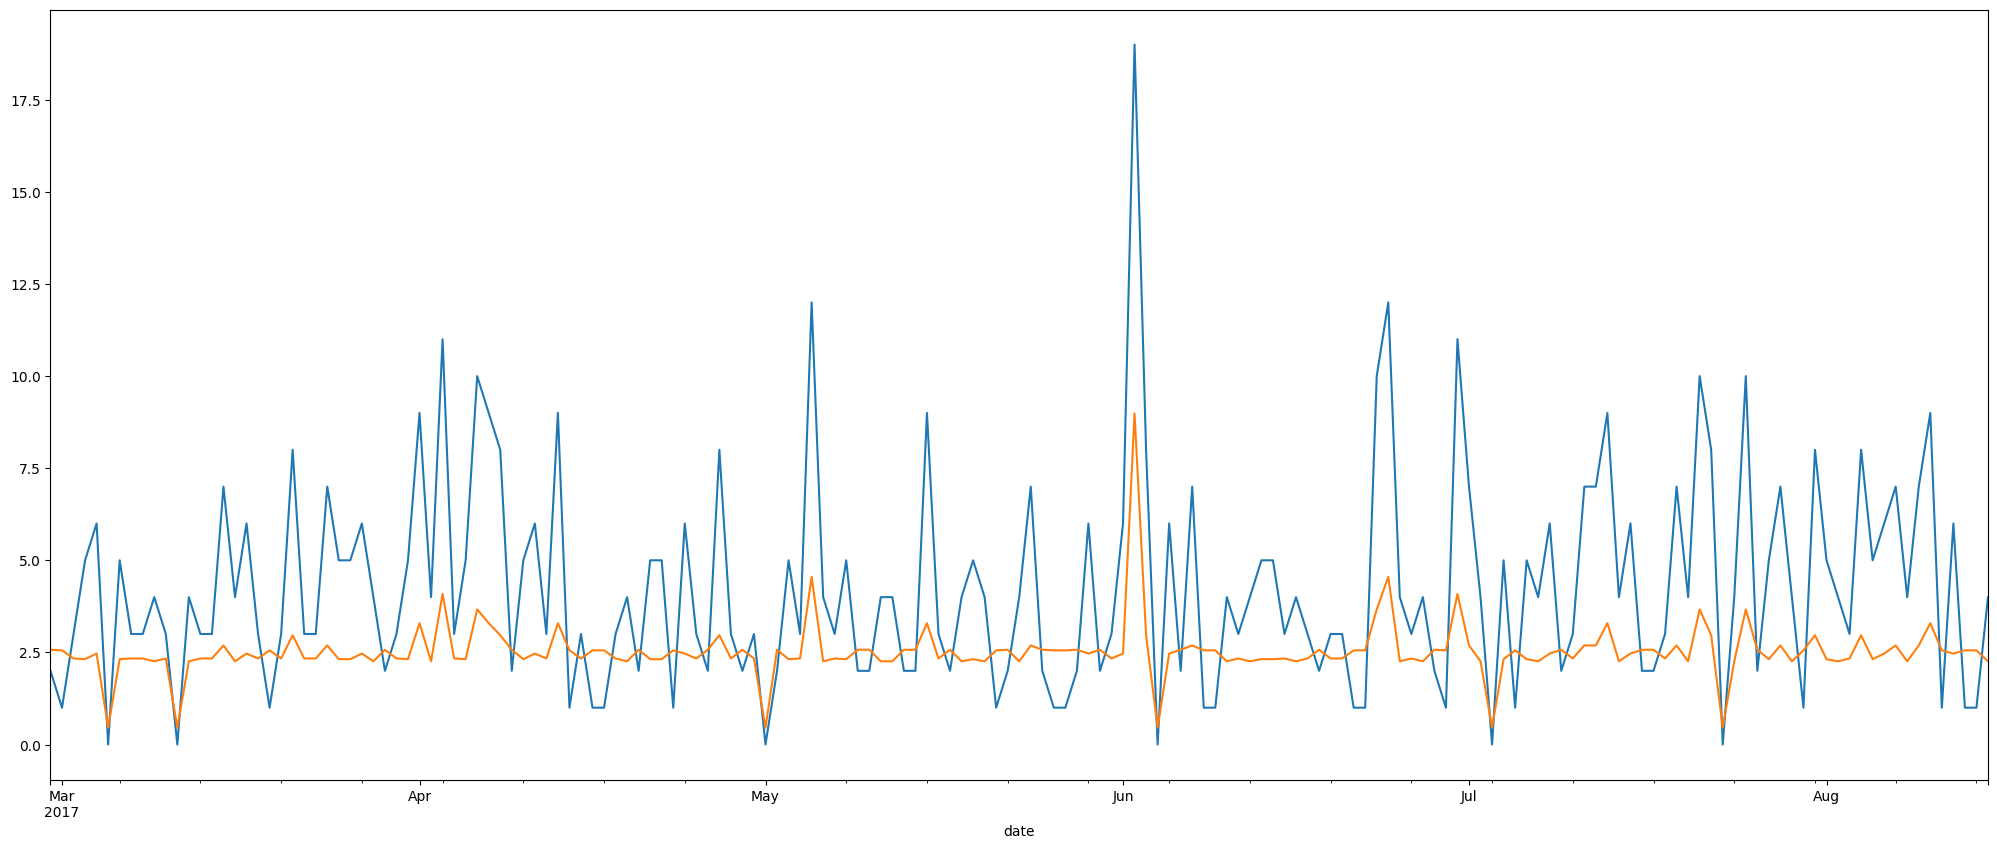

In [24]:
compare('1_AUTOMOTIVE')

R2 Score: -4.333718381903976
RMSLE: 1.1910282745724952


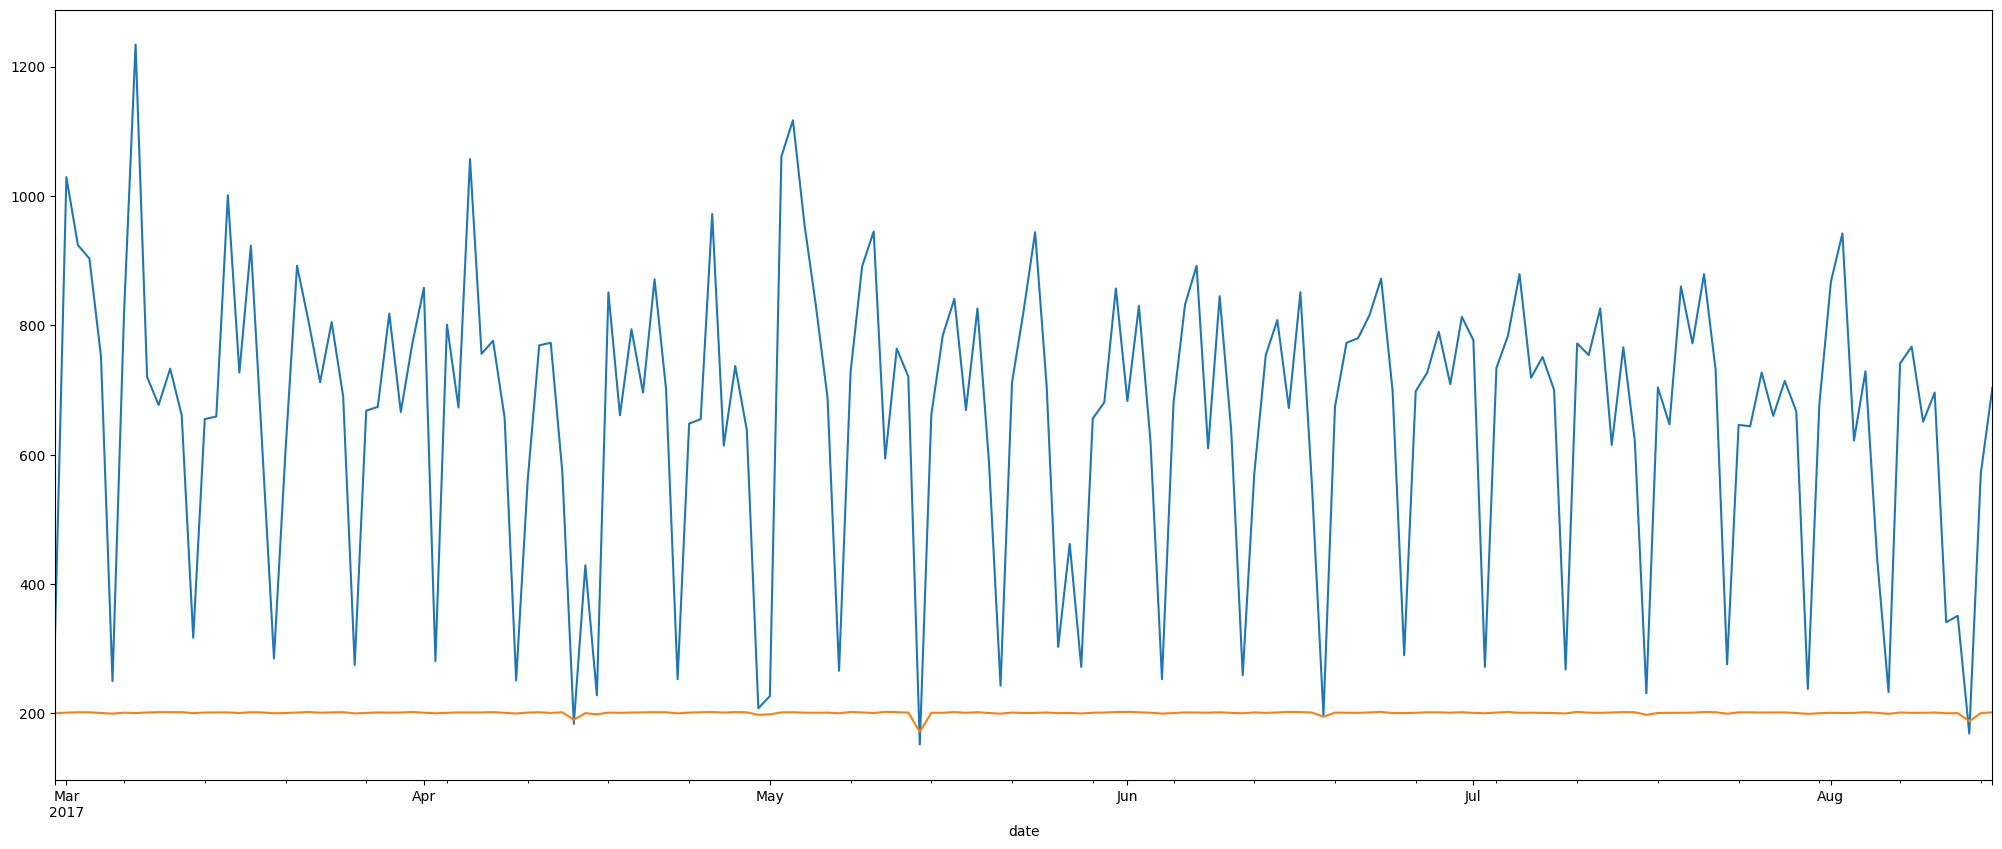

In [25]:
compare('1_CLEANING')

R2 Score: -7.002032216540304
RMSLE: 1.2633981884764234


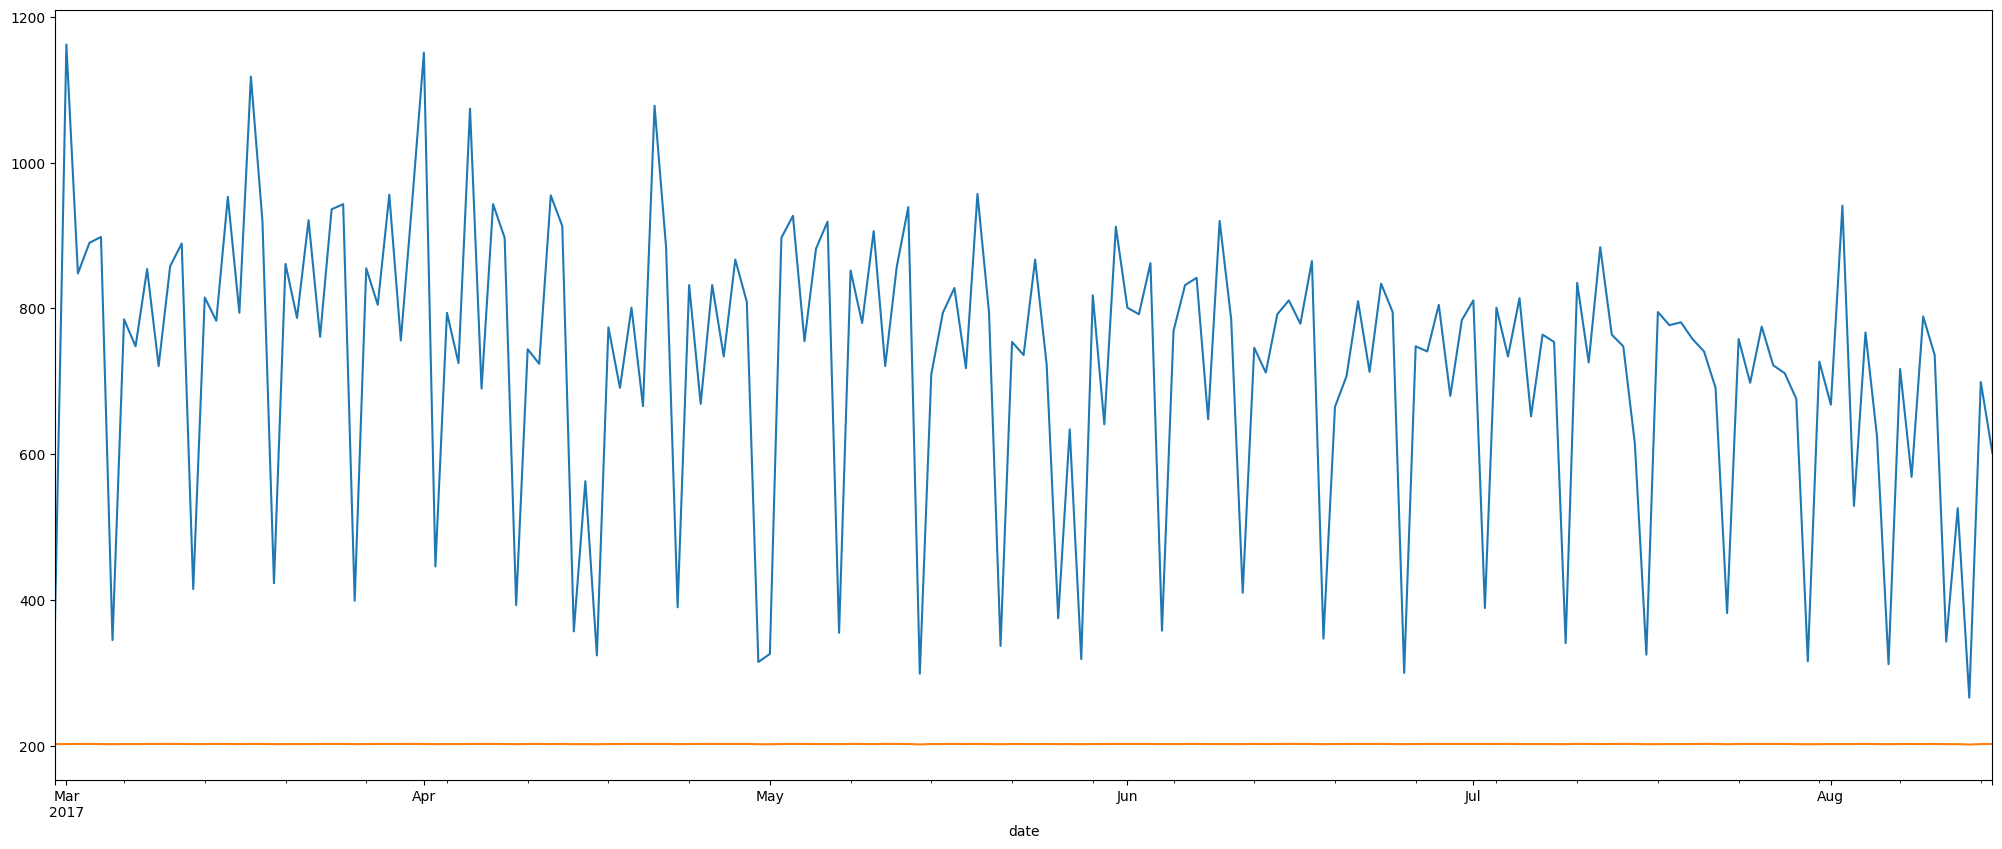

In [26]:
compare('1_DAIRY')

R2 Score: 0.8306565591778922
RMSLE: 0.1779816817716817


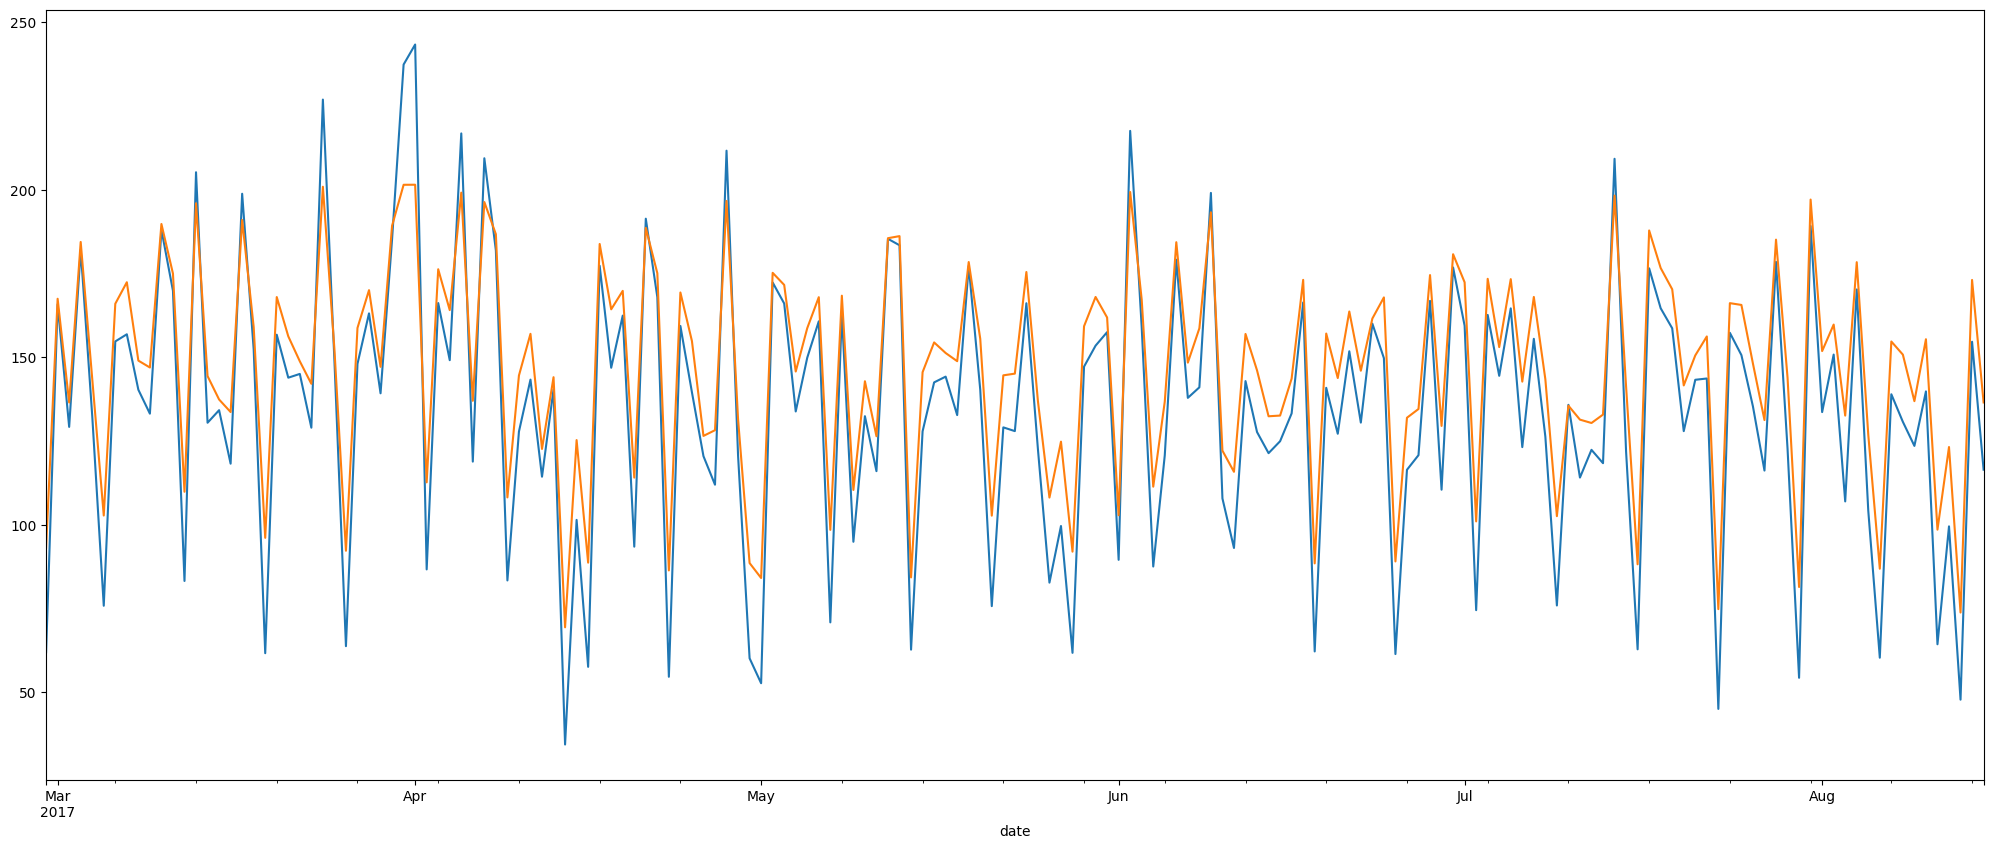

In [27]:
compare('1_DELI')

## LSTM Submission

In [28]:
Y = pd.DataFrame()
for feature in train.columns:
    for step in range(1, 17):
        Y[f'{feature}_step_ahead_{step}'] = train[feature].shift(-step, fill_value=0)
Y

,1_AUTOMOTIVE_step_ahead_1,1_AUTOMOTIVE_step_ahead_2,1_AUTOMOTIVE_step_ahead_3,1_AUTOMOTIVE_step_ahead_4,1_AUTOMOTIVE_step_ahead_5,1_AUTOMOTIVE_step_ahead_6,1_AUTOMOTIVE_step_ahead_7,1_AUTOMOTIVE_step_ahead_8,1_AUTOMOTIVE_step_ahead_9,1_AUTOMOTIVE_step_ahead_10,...,54_SEAFOOD_step_ahead_7,54_SEAFOOD_step_ahead_8,54_SEAFOOD_step_ahead_9,54_SEAFOOD_step_ahead_10,54_SEAFOOD_step_ahead_11,54_SEAFOOD_step_ahead_12,54_SEAFOOD_step_ahead_13,54_SEAFOOD_step_ahead_14,54_SEAFOOD_step_ahead_15,54_SEAFOOD_step_ahead_16
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,2.0,3.0,3.0,5.0,2.0,0.0,2.0,2.0,2.0,3.0,...,1.0,1.0,1.0,0.0,1.0,5.0,0.0,2.0,1.0,2.0
2013-01-02,3.0,3.0,5.0,2.0,0.0,2.0,2.0,2.0,3.0,2.0,...,1.0,1.0,0.0,1.0,5.0,0.0,2.0,1.0,2.0,0.0
2013-01-03,3.0,5.0,2.0,0.0,2.0,2.0,2.0,3.0,2.0,2.0,...,1.0,0.0,1.0,5.0,0.0,2.0,1.0,2.0,0.0,1.0
2013-01-04,5.0,2.0,0.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,...,0.0,1.0,5.0,0.0,2.0,1.0,2.0,0.0,1.0,7.0
2013-01-05,2.0,0.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0,1.0,...,1.0,5.0,0.0,2.0,1.0,2.0,0.0,1.0,7.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,6.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-12,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-13,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, random_state=5, shuffle=False)
X_test_copy = X_test
X_test_index = X_test.index
X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train = y_train.values.reshape(y_train.shape[0], 1782, 16)
y_test = y_test.values.reshape(y_test.shape[0], 1782, 16)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1515, 1782, 1)
(169, 1782, 1)
(1515, 1782, 16)
(169, 1782, 16)


In [30]:
lstm = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[X_train.shape[1], X_train.shape[2]]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.Dense(16)
])
lstm.compile(loss=keras.losses.MeanSquaredLogarithmicError(), optimizer=tf.keras.optimizers.Adam())
lstm.summary()
lstm.fit(X_train, y_train, epochs=100, callbacks=[es])
pred_lstm = abs(lstm.predict(X_test))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1782, 100)         40800     
                                                                 
 lstm_4 (LSTM)               (None, 1782, 100)         80400     
                                                                 
 lstm_5 (LSTM)               (None, 1782, 100)         80400     
                                                                 
 dense_3 (Dense)             (None, 1782, 16)          1616      
                                                                 
Total params: 203,216
Trainable params: 203,216
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
48/48 [==============================] - 10s 152ms/step - loss: 10.1644
Epoch 2/100
48/48 [==============================] - 7s 151ms/step - loss: 8.3947
Epoch 3/100
48

In [31]:
pred = pd.DataFrame(pred_lstm[168].T, columns=X.columns, index=test.index.unique())
pred

,1_AUTOMOTIVE,1_BABY CARE,1_BEAUTY,1_BEVERAGES,1_BOOKS,1_BREAD_BAKERY,1_CELEBRATION,1_CLEANING,1_DAIRY,1_DELI,...,54_MAGAZINES,54_MEATS,54_PERSONAL CARE,54_PET SUPPLIES,54_PLAYERS AND ELECTRONICS,54_POULTRY,54_PREPARED FOODS,54_PRODUCE,54_SCHOOL AND OFFICE SUPPLIES,54_SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,2.355941,1.059757,1.908306,157.504715,0.428838,160.524338,10.144552,160.787857,160.782837,156.893005,...,1.128864,78.109482,160.269302,0.317271,2.903761,91.770569,77.976257,160.761703,0.007412,2.547208
2017-08-17,2.192654,0.989042,1.943323,142.463669,0.272173,145.193161,9.786385,145.426834,145.422226,142.074112,...,1.196305,72.806023,144.971176,0.395756,2.966816,85.296989,72.847687,145.403793,0.115458,2.627259
2017-08-18,2.207404,0.965431,1.988186,143.955368,0.348896,146.705292,10.030747,146.940765,146.936188,143.553467,...,1.183352,72.603310,146.473190,0.343690,2.983583,85.300606,73.168137,146.917206,0.040746,2.637166
2017-08-19,2.068743,0.617542,2.118440,114.562157,0.229112,116.787209,10.060716,116.965714,116.962761,114.569527,...,1.087418,62.617920,116.630516,0.320892,2.979789,72.558090,63.822502,116.948967,0.051001,2.669460
2017-08-20,2.283131,0.846595,2.051922,142.906082,0.271756,145.651688,9.819310,145.883759,145.879059,142.473679,...,1.152723,71.727234,145.418472,0.383422,2.996592,84.308388,72.016777,145.860153,0.100670,2.658474
2017-08-21,2.218533,0.755243,2.015010,138.090546,0.243749,140.743195,9.832994,140.961960,140.957489,137.727997,...,1.110307,70.596939,140.520050,0.369947,2.950200,82.610710,71.144218,140.939423,0.097933,2.638567
2017-08-22,2.396008,0.757386,2.012664,149.890427,0.281276,152.778595,10.095300,153.016403,153.011581,149.462997,...,1.108099,75.103394,152.528442,0.339561,2.887720,88.209122,75.470634,152.991577,0.072494,2.572216
2017-08-23,2.363967,0.729325,2.116335,141.547348,0.246481,144.267929,9.710745,144.499680,144.495163,141.180557,...,1.207145,71.880989,144.042755,0.405704,3.029186,84.201561,72.114235,144.476395,0.125322,2.698147
2017-08-24,2.475238,0.786162,2.097929,154.441269,0.272514,157.396942,9.971336,157.647247,157.641876,153.859863,...,1.180611,76.756874,157.135712,0.404360,3.041157,90.398643,76.931274,157.621368,0.120210,2.709663


In [32]:
id = []
sales = []
for i in test.id:
    row = test[test['id'] == i]
    column = f"{row['store_nbr'][0]}_{row['family'][0].replace('/', '_')}"
    value = pred[column][pred.index == row.index[0]][0]
    # The info from the ID row is taken and used to form a variable called column. 
    # This column variable refers to the correct store in the dataframe and the equality check on the indexes refer to the proper dates lining up.
    id.append(i)
    sales.append(value)
lstm_submission = pd.DataFrame({'id': id, 'sales': sales})
lstm_submission

,id,sales
0,3000888,2.355941
1,3000889,1.059757
2,3000890,1.908306
3,3000891,157.504715
4,3000892,0.428838
...,...,...
28507,3029395,146.226639
28508,3029396,142.493179
28509,3029397,146.266418
28510,3029398,49.064888


In [33]:
lstm_submission.to_csv('LSTM_submission.csv', header=True, index=False)